<a href="https://colab.research.google.com/github/UnitForDataScience/Projects-Fall-2024/blob/main/ConsumerVoice/Text_Classification_with_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [77]:
!pip install wordcloud
!pip install xgboost lightgbm --quiet

In [78]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier,
    AdaBoostClassifier,
    GradientBoostingClassifier,
    ExtraTreesClassifier)

from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

import time
import re
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud

# Suppress warnings for clean output
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
RANDOM_STATE = 42

## Load Data

Link to download data: [link text](https://www.kaggle.com/datasets/namigabbasov/consumer-complaint-dataset)

In [79]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [80]:
file_path = '/content/drive/MyDrive/Projects /Projects-Fall-2024/ConsumerVoice/complaints.csv'
df = pd.read_csv(file_path)
df= df.sample(frac=0.01, random_state=42)  # using only 5 percent of data because of high computation

## Explore Data

In [81]:
df["Product"].value_counts()

,count
Product,
"Credit reporting, credit repair services, or other personal consumer reports",8138
Credit reporting or other personal consumer reports,3688
Debt collection,2608
Mortgage,1194
Credit card or prepaid card,1077
Checking or savings account,1011
Credit card,504
Student loan,450
"Money transfer, virtual currency, or money service",432


<Axes: ylabel='count'>

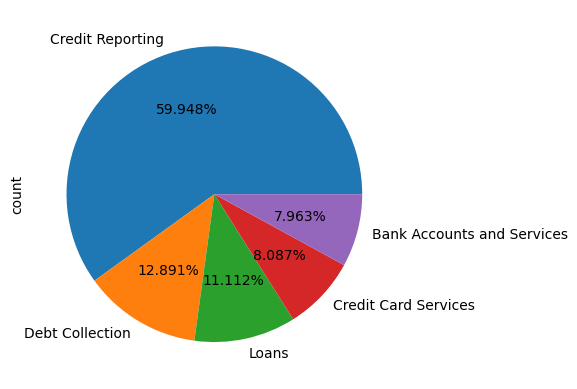

In [82]:
df["product_5"].value_counts().head(10).plot(kind="pie", autopct="%.3f%%")

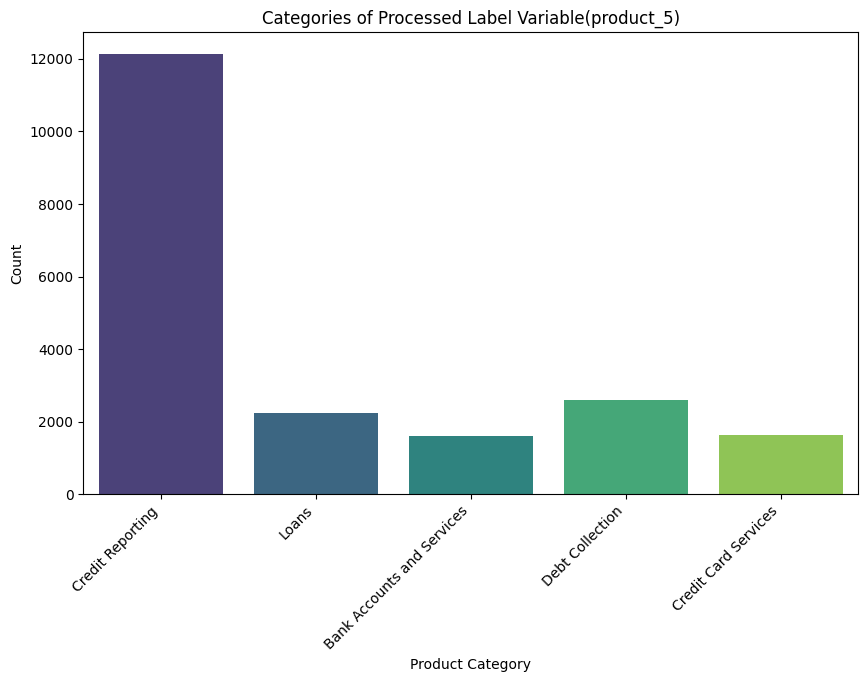

In [83]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x="product_5", palette="viridis")
plt.title("Categories of Processed Label Variable(product_5)")
plt.xlabel("Product Category")
plt.ylabel("Count")
plt.xticks(rotation=45, ha="right")
plt.show()

In [84]:
df.duplicated().sum()

0

In [85]:
df.isnull().sum()

,0
Unnamed: 0,0
product_5,0
narrative,0
Product,0
Date received,0
Sub-product,523
Issue,0
Sub-issue,2293
Company,0
State,62


In [86]:
df["narrative"].iloc[20000]

"My daughter applied for a XXXX XXXX XXXX  from XXXX XXXX. She went to their site to see if she would prequalify for a card without any impact to her credit bureau score. The pre-qualify said she didn't qualify so she used me as a co-signer, again using the prequalify on-line application. We were both denied, end of story. Unfortunately XXXX XXXX  reported the denied application to all 3 credit bureaus as a declined loan, thus lowering my score between 3-9 points. This was supposed to be a prequalify, not an actual application."

In [87]:
df = df[['product_5', 'narrative']]
pd.set_option('display.max_colwidth', None)
df.head()

,product_5,narrative
552588,Credit Reporting,"I have asked XXXX XXXX and experian to have XXXX XXXX XXXX, XXXX XXXX XXXX and XXXX XXXX XXXX to provide proof of contract with my signature on it stating I owe these collection companys money and if proof of contract is not provided to have them deleted immediately"
487309,Credit Reporting,"This is my fourth endeavor to tell you that I am a victim of identity theft and I complain to question specific records in my document coming about because of the wrongdoing. The records I am questioning connect with no exchanges acquiring any possession of goods, services, or money that I have made or authorized. Assuming no one cares, either way, block the noteworthy of any information in my credit record that came about due to alleged fraud or extortion. \nXXXX XXXX XXXX XXXX, HI XXXX ; XXXXXXXX XXXX XXXXXXXX Balance : {$1400.00} ; XXXX XXXX XXXX XXXX Balance : {$3300.00} ; XXXX XXXX XXXX XXXX XXXX XXXX XXXX {$12000.00} ; XXXXXXXX XXXX XXXXXXXX Balance : {$11000.00} ; XXXXXXXX XXXX XXXX XXXX XXXXXXXX Balance XXXX {$6000.00} XXXX XXXX XX/XX/2021 ;"
1549092,Loans,I took out a small loan which I thought was a payday type of loan for {$1200.00}. \n\nI was approved over the phone. \n\nThey credit my bank account on XX/XX/XXXX for {$1200.00}. \n\nI thought that I would only need to pay 4 payments of {$340.00} to cover the cost of the loan and interest. They were not clear with the loan agreement.\n\nI made 4 payments of {$340.00} on XX/XX/XXXX XX/XX/XXXX XX/XX/XXXX XX/XX/XXXX This is a total payment of {$1300.00} for a {$1200.00} loan ( XXXX in interest ). \n\nThey attempted a 5th payment of XXXX on XX/XX/XXXX which I do not authorize and was surprised to see hit my account since I thought I had paid off this loan. \n\nI immediately called them to ask them about this and they told me that per the loan agreement that I owe them 20 payments of {$340.00}. This amount of payments was never disclosed to me over the phone when I was approved for the loan or thereafter. I would never have agreed to 20 payments of {$340.00} with them for a {$1200.00} loan. That is beyond predatory or reasonable. \n\nAfter getting on the phone with them I tried to access my account with them on their website and I entered my email address and last four of my social and still could not log in to see any documentation regarding my loan. I have no documentation nor did I ever receive documentation prior to agreeing to this loan. The approval process was done over the phone. \n\nI am filing this complaint because they are not being upfront with customers about loan terms and agreements and fees and they are being predatory in charging excessive interest rates. Furthermore they are preying upon poor people and exploiting American consumers with these practices.
1359447,Loans,"Wells Fargo is creating false statements and including them on formal documents. They sent me an escrow analysis, which is a formal legal document, during the 1st week of XX/XX/XXXX and on the document they wrote that I had a XXXX overage but that they would not send it to me because I was delinquent. \nThat statement that I was delinquent was a false statement and by putting it in the document Wells Fargo is making it an official record. The Facts are my payments are not delinquent, and have not been. Here are the dates that Wells Fargo has cashed my monthly ACH transfers. \nXXXX {$850.00} XXXX {$850.00} XXXX {$850.00} XXXX {$850.00} XXXX {$850.00}XX/XX/XXXX {$850.00}XX/XX/XXXX {$850.00} fee added XXXX ( XXXX )XX/XX/XXXX {$850.00}XX/XX/XXXX {$850.00} This Loan is a VA Loan and the VA has made it very clear to Wells Fargo that my payments are not late until after the XXXX of each month. Yet I am receiving many harassing calls from Wells Fargo. They call over and over again and then when I dont answer they dont leave any message. In addition, Wells Fargo monthy statement they send me each month clearly says that if I should send payment after the XXXX to ad

In [88]:
# Define the mapping
category_mapping = {
    'Credit Reporting': 0,
    'Debt Collection': 1,
    'Loans': 2,
    'Credit Card Services': 3,
    'Bank Accounts and Services': 4
}

# Recode the 'product_5' variable
df['product_5'] = df['product_5'].map(category_mapping)

## Text Preprocessing  

In [89]:
import re
from nltk.corpus import stopwords

# Ensure stopwords are downloaded
import nltk
nltk.download('stopwords')

# Regular Expressions for text cleaning
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')  # Keep lowercase letters, digits, and some special characters
STOPWORDS = set(stopwords.words('english'))

# function to clean text
def clean_text(text):
    """
    text: a string
    return: cleaned and preprocessed string
    """
    text = str(text).lower()  # Convert text to lowercase
    text = REPLACE_BY_SPACE_RE.sub(' ', text)  # Replace certain symbols with a space
    text = BAD_SYMBOLS_RE.sub('', text)  # Remove unwanted symbols
    text = ' '.join(word for word in text.split() if word not in STOPWORDS)  # Remove stopwords
    return text


df['cleaned_narrative'] = df['narrative'].apply(clean_text)

# verify cleaning process
print(df[['narrative', 'cleaned_narrative']].head())

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Text Vectorization

In [90]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

# initialize TF-IDF vectorizer
tfidf = TfidfVectorizer(max_features=3000, ngram_range=(1, 2))

# fit and transform cleaned narratives
X_tfidf = tfidf.fit_transform(df['cleaned_narrative'])

# Check shape of transformed data
print(X_tfidf.shape)

(20231, 3000)


In [91]:
y = df['product_5']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

# Check shapes of resulting sets
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(16184, 3000) (4047, 3000) (16184,) (4047,)


Training Logistic Regression...
Training time for Logistic Regression: 2.0118 seconds
Prediction time for Logistic Regression: 0.0041 seconds
Logistic Regression Accuracy: 0.8634
Classification Report for Logistic Regression:

              precision    recall  f1-score   support

           0       0.89      0.95      0.92      2414
           1       0.82      0.65      0.72       542
           2       0.85      0.83      0.84       461
           3       0.74      0.63      0.68       316
           4       0.82      0.84      0.83       314

    accuracy                           0.86      4047
   macro avg       0.82      0.78      0.80      4047
weighted avg       0.86      0.86      0.86      4047



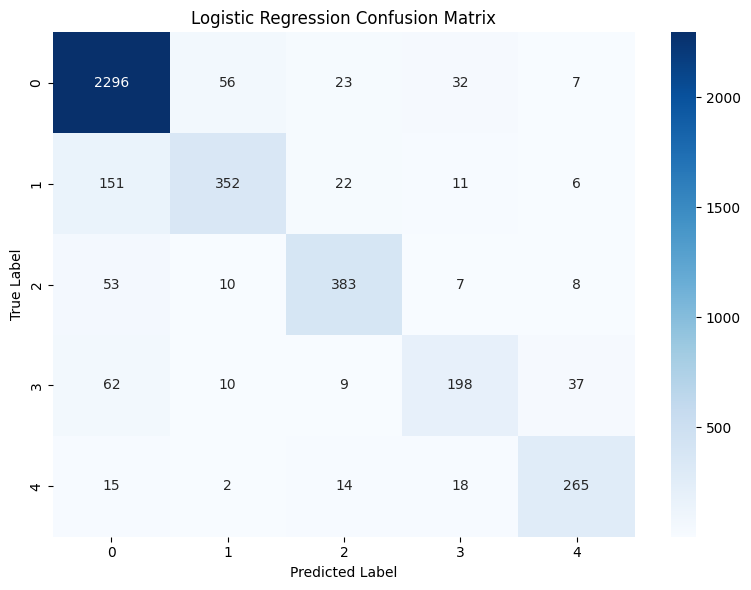


------------------------------------------------------------

Training Multinomial Naive Bayes...
Training time for Multinomial Naive Bayes: 0.0140 seconds
Prediction time for Multinomial Naive Bayes: 0.0048 seconds
Multinomial Naive Bayes Accuracy: 0.8342
Classification Report for Multinomial Naive Bayes:

              precision    recall  f1-score   support

           0       0.91      0.90      0.90      2414
           1       0.74      0.61      0.67       542
           2       0.72      0.89      0.79       461
           3       0.67      0.58      0.62       316
           4       0.78      0.89      0.83       314

    accuracy                           0.83      4047
   macro avg       0.76      0.77      0.76      4047
weighted avg       0.83      0.83      0.83      4047



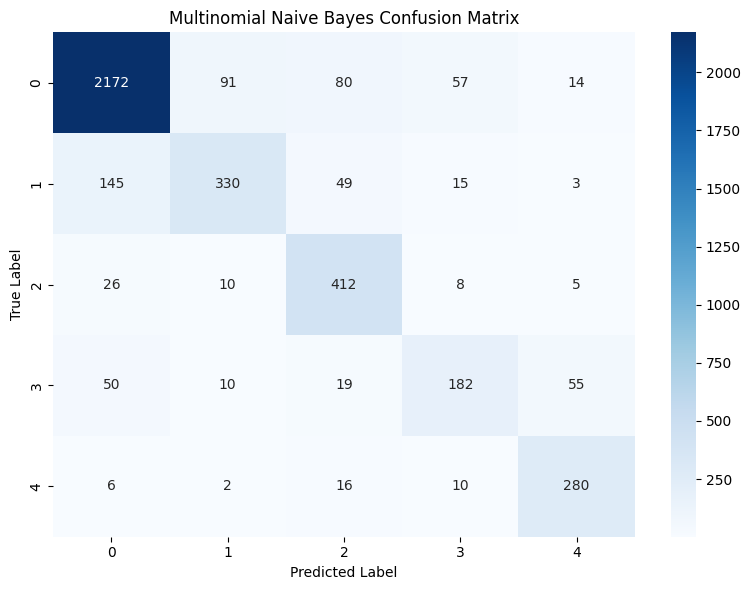


------------------------------------------------------------

Training K-Nearest Neighbors...
Training time for K-Nearest Neighbors: 0.0076 seconds
Prediction time for K-Nearest Neighbors: 80.4366 seconds
K-Nearest Neighbors Accuracy: 0.7840
Classification Report for K-Nearest Neighbors:

              precision    recall  f1-score   support

           0       0.81      0.95      0.87      2414
           1       0.75      0.46      0.57       542
           2       0.73      0.62      0.67       461
           3       0.63      0.48      0.55       316
           4       0.78      0.64      0.70       314

    accuracy                           0.78      4047
   macro avg       0.74      0.63      0.67      4047
weighted avg       0.78      0.78      0.77      4047



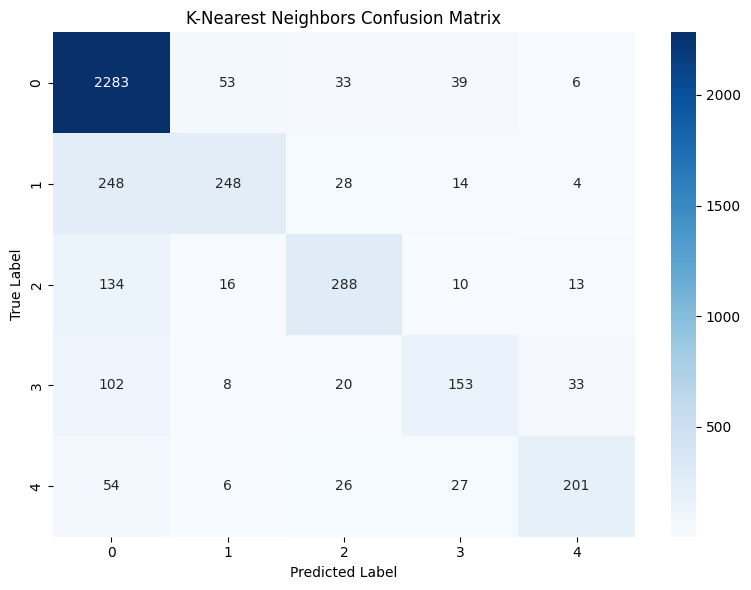


------------------------------------------------------------

Training Decision Tree...
Training time for Decision Tree: 11.8235 seconds
Prediction time for Decision Tree: 0.0119 seconds
Decision Tree Accuracy: 0.7482
Classification Report for Decision Tree:

              precision    recall  f1-score   support

           0       0.84      0.87      0.86      2414
           1       0.57      0.52      0.54       542
           2       0.67      0.65      0.66       461
           3       0.48      0.47      0.48       316
           4       0.66      0.62      0.64       314

    accuracy                           0.75      4047
   macro avg       0.64      0.63      0.63      4047
weighted avg       0.74      0.75      0.75      4047



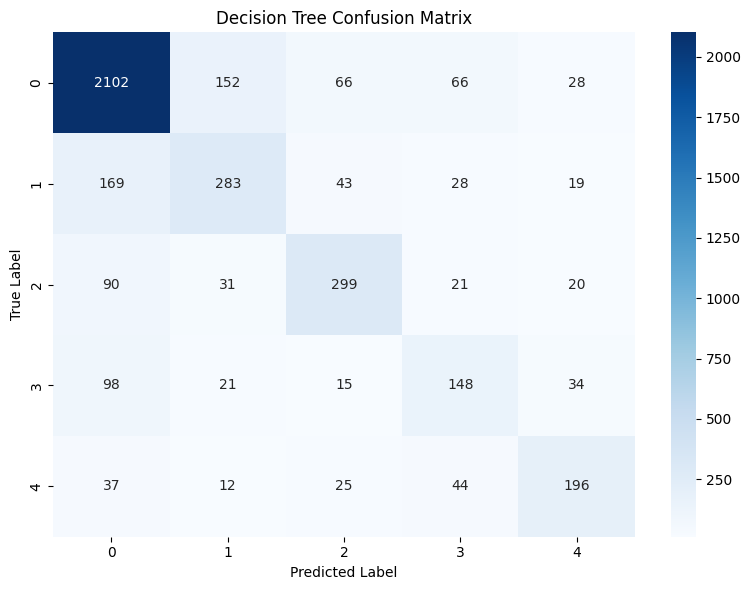


------------------------------------------------------------

Training Random Forest...
Training time for Random Forest: 4.3345 seconds
Prediction time for Random Forest: 0.0888 seconds
Random Forest Accuracy: 0.8537
Classification Report for Random Forest:

              precision    recall  f1-score   support

           0       0.86      0.97      0.91      2414
           1       0.84      0.58      0.69       542
           2       0.86      0.78      0.82       461
           3       0.81      0.58      0.68       316
           4       0.81      0.84      0.82       314

    accuracy                           0.85      4047
   macro avg       0.84      0.75      0.78      4047
weighted avg       0.85      0.85      0.85      4047



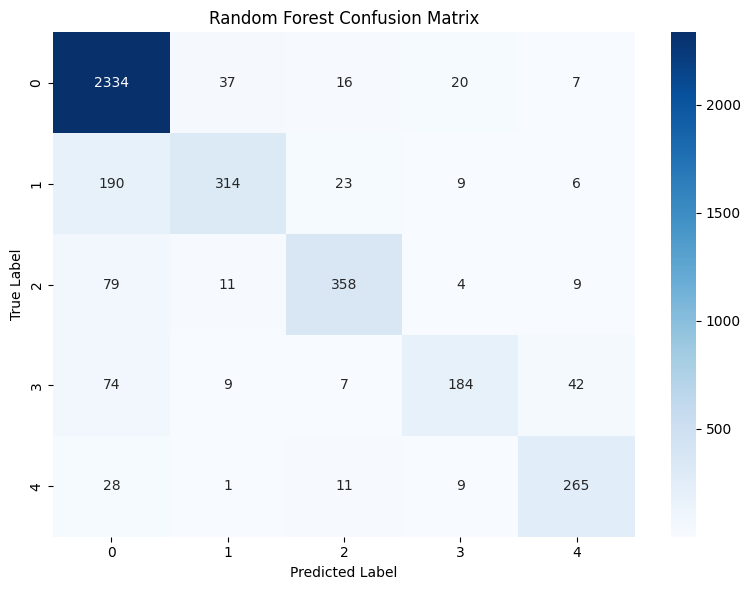


------------------------------------------------------------

Training Extra Trees...
Training time for Extra Trees: 5.6594 seconds
Prediction time for Extra Trees: 0.0916 seconds
Extra Trees Accuracy: 0.8545
Classification Report for Extra Trees:

              precision    recall  f1-score   support

           0       0.86      0.97      0.92      2414
           1       0.86      0.56      0.68       542
           2       0.83      0.80      0.81       461
           3       0.84      0.54      0.66       316
           4       0.80      0.87      0.83       314

    accuracy                           0.85      4047
   macro avg       0.84      0.75      0.78      4047
weighted avg       0.85      0.85      0.85      4047



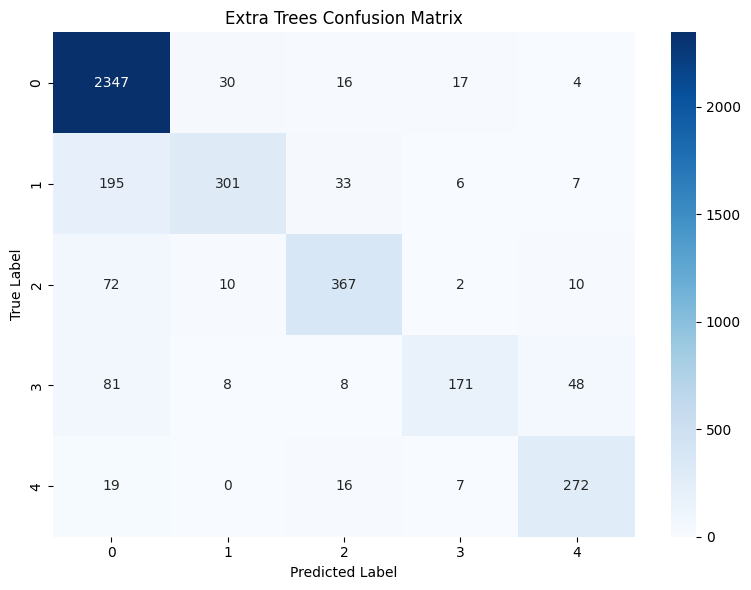


------------------------------------------------------------

Training AdaBoost...
Training time for AdaBoost: 9.4551 seconds
Prediction time for AdaBoost: 0.5529 seconds
AdaBoost Accuracy: 0.8055
Classification Report for AdaBoost:

              precision    recall  f1-score   support

           0       0.85      0.92      0.88      2414
           1       0.71      0.52      0.60       542
           2       0.80      0.75      0.77       461
           3       0.60      0.55      0.57       316
           4       0.74      0.77      0.75       314

    accuracy                           0.81      4047
   macro avg       0.74      0.70      0.72      4047
weighted avg       0.80      0.81      0.80      4047



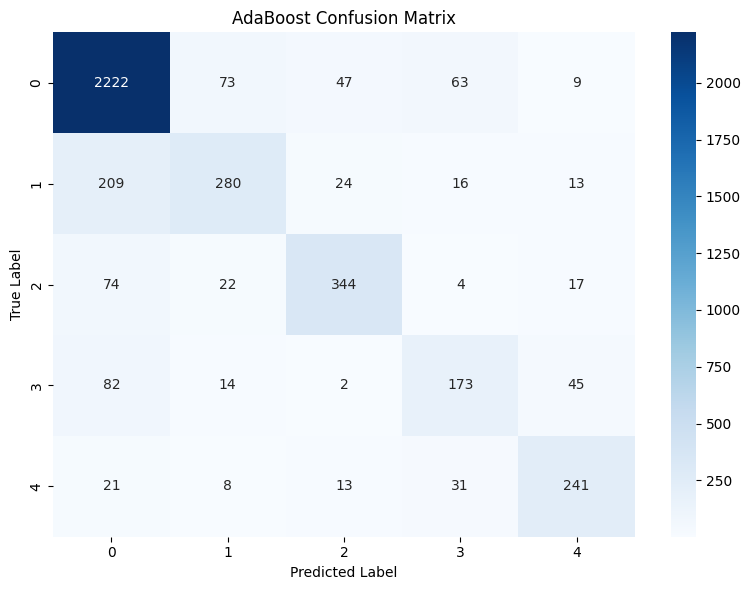


------------------------------------------------------------

Training Gradient Boosting...
Training time for Gradient Boosting: 164.2844 seconds
Prediction time for Gradient Boosting: 0.0376 seconds
Gradient Boosting Accuracy: 0.8500
Classification Report for Gradient Boosting:

              precision    recall  f1-score   support

           0       0.87      0.95      0.91      2414
           1       0.79      0.63      0.70       542
           2       0.86      0.78      0.82       461
           3       0.76      0.63      0.69       316
           4       0.82      0.80      0.81       314

    accuracy                           0.85      4047
   macro avg       0.82      0.76      0.78      4047
weighted avg       0.85      0.85      0.85      4047



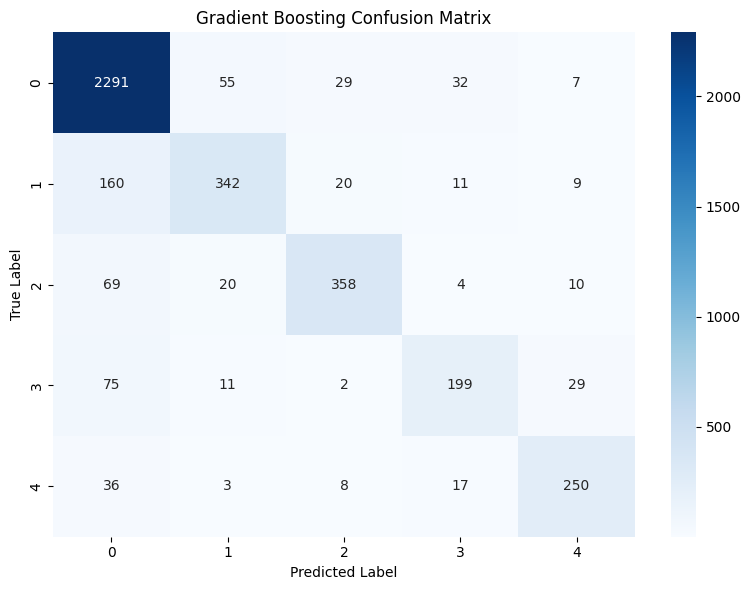


------------------------------------------------------------

Training XGBoost...
Training time for XGBoost: 51.8028 seconds
Prediction time for XGBoost: 0.0227 seconds
XGBoost Accuracy: 0.8676
Classification Report for XGBoost:

              precision    recall  f1-score   support

           0       0.90      0.95      0.92      2414
           1       0.81      0.69      0.75       542
           2       0.84      0.82      0.83       461
           3       0.74      0.66      0.69       316
           4       0.82      0.84      0.83       314

    accuracy                           0.87      4047
   macro avg       0.82      0.79      0.81      4047
weighted avg       0.86      0.87      0.86      4047



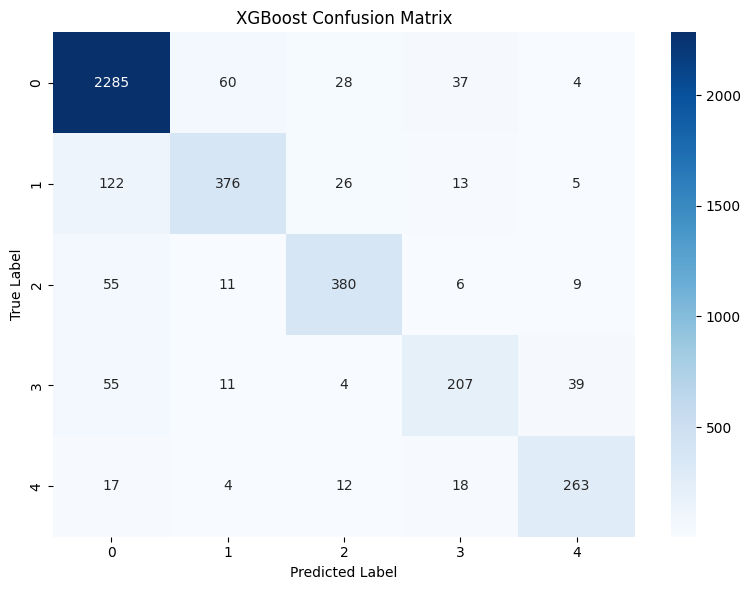


------------------------------------------------------------

Training LightGBM...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.189200 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 258065
[LightGBM] [Info] Number of data points in the train set: 16184, number of used features: 2997
[LightGBM] [Info] Start training from score -0.510455
[LightGBM] [Info] Start training from score -2.058409
[LightGBM] [Info] Start training from score -2.203485
[LightGBM] [Info] Start training from score -2.506391
[LightGBM] [Info] Start training from score -2.523969
Training time for LightGBM: 18.0841 seconds
Prediction time for LightGBM: 0.0703 seconds
LightGBM Accuracy: 0.8713
Classification Report for LightGBM:

              precision    recall  f1-score   support

           0       0.91      0.95      0.93      2414
           1       0.80     

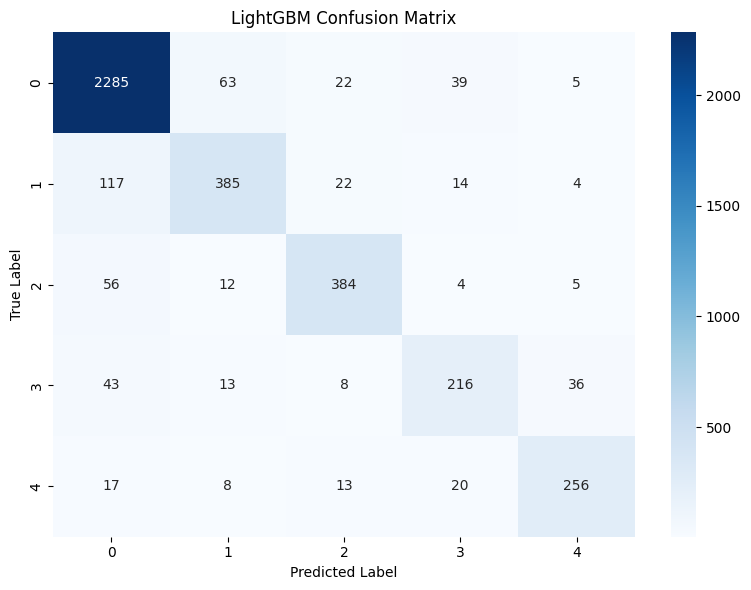


------------------------------------------------------------

Training Linear SVM...
Training time for Linear SVM: 0.4367 seconds
Prediction time for Linear SVM: 0.0033 seconds
Linear SVM Accuracy: 0.8569
Classification Report for Linear SVM:

              precision    recall  f1-score   support

           0       0.90      0.93      0.92      2414
           1       0.76      0.67      0.71       542
           2       0.84      0.82      0.83       461
           3       0.71      0.65      0.68       316
           4       0.81      0.86      0.83       314

    accuracy                           0.86      4047
   macro avg       0.80      0.79      0.79      4047
weighted avg       0.85      0.86      0.85      4047



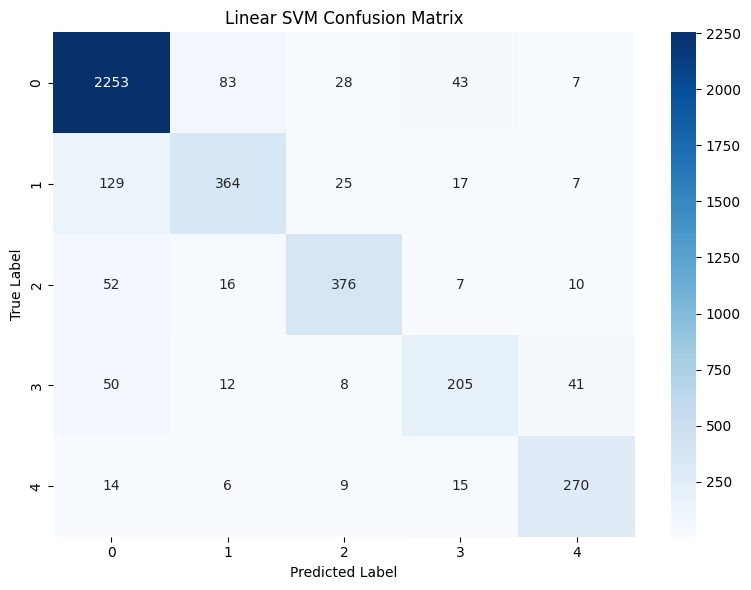


------------------------------------------------------------

Training RBF SVM...
Training time for RBF SVM: 78.2142 seconds
Prediction time for RBF SVM: 18.1194 seconds
RBF SVM Accuracy: 0.8693
Classification Report for RBF SVM:

              precision    recall  f1-score   support

           0       0.90      0.95      0.92      2414
           1       0.83      0.68      0.74       542
           2       0.85      0.83      0.84       461
           3       0.74      0.64      0.69       316
           4       0.84      0.85      0.85       314

    accuracy                           0.87      4047
   macro avg       0.83      0.79      0.81      4047
weighted avg       0.87      0.87      0.87      4047



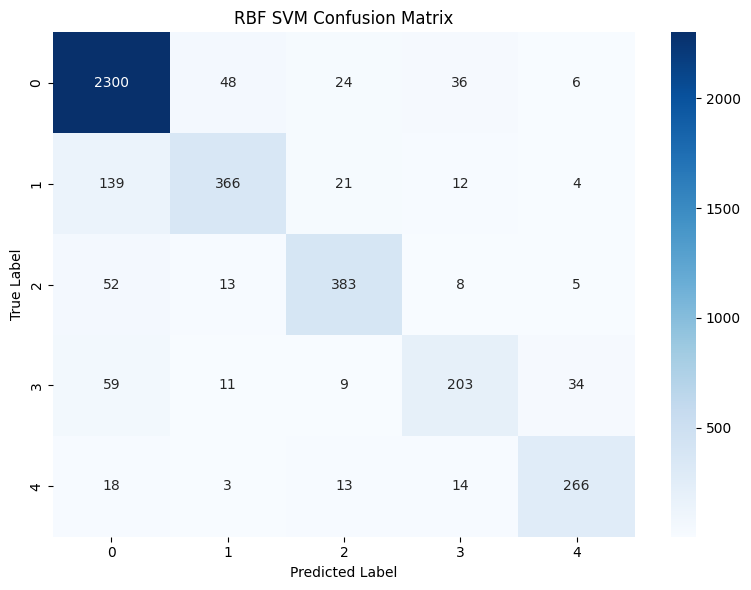


------------------------------------------------------------



In [92]:
# Define a dictionary of classifiers
classifiers = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=RANDOM_STATE),
    "Multinomial Naive Bayes": MultinomialNB(),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(random_state=RANDOM_STATE),
    "Random Forest": RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=RANDOM_STATE),
    "Extra Trees": ExtraTreesClassifier(n_estimators=100, n_jobs=-1, random_state=RANDOM_STATE),
    "AdaBoost": AdaBoostClassifier(random_state=RANDOM_STATE),
    "Gradient Boosting": GradientBoostingClassifier(random_state=RANDOM_STATE),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=RANDOM_STATE),
    "LightGBM": LGBMClassifier(random_state=RANDOM_STATE),
    "Linear SVM": LinearSVC(random_state=RANDOM_STATE),
    "RBF SVM": SVC(kernel='rbf', random_state=RANDOM_STATE)
}

# Function to plot confusion matrix
def plot_confusion_matrix(cm, classes, title, cmap=plt.cm.Blues):
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, xticklabels=classes, yticklabels=classes)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Iterate through classifiers
for name, clf in classifiers.items():
    print(f"Training {name}...")

    # Measure start time
    start_time = time.time()

    # Train the classifier
    clf.fit(X_train, y_train)

    # Measure end time for training
    train_time = time.time() - start_time
    print(f"Training time for {name}: {train_time:.4f} seconds")

    # Measure start time for prediction
    start_time = time.time()

    # Predict
    y_pred = clf.predict(X_test)

    # Measure end time for prediction
    prediction_time = time.time() - start_time
    print(f"Prediction time for {name}: {prediction_time:.4f} seconds")

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{name} Accuracy: {accuracy:.4f}")

    # Classification report
    print(f"Classification Report for {name}:\n")
    print(classification_report(y_test, y_pred))

    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Plot confusion matrix
    plot_confusion_matrix(cm, classes=clf.classes_, title=f"{name} Confusion Matrix")

    print("\n" + "-"*60 + "\n")


### Check sample text

In [93]:
# New text input
new_text = ["In January 2024, I entered into a contract with XXXX rental agency to rent a vehicle for a business trip. I used my debit card to secure the rental, and a pre-authorization hold of $500.00 was placed on my account. This hold was supposed to cover any potential damages or additional fees that might arise during the rental period"]

# Step 1: Preprocess the new text
def clean_text(text):
    REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
    BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
    STOPWORDS = set(stopwords.words('english'))

    text = str(text).lower()
    text = REPLACE_BY_SPACE_RE.sub(' ', text)
    text = BAD_SYMBOLS_RE.sub('', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS)
    return text

cleaned_text = [clean_text(text) for text in new_text]

#Transform the text using the same TF-IDF vectorizer
X_new = tfidf.transform(cleaned_text)

#Predict using one of models above: Logistic Regression
predicted_label = classifiers["Logistic Regression"].predict(X_new)

# Output predicted label
print(f"Predicted Label: {predicted_label[0]}")


Predicted Label: 4


## Next Steps
The results suggest that the models have harder time in identiying "Debt Collection" and "Credit Card Services". This could be because of collapsing several categorties under 5 categories. The following steps could be taken to imporve models:

1. Model optimization
2. Balancing the labels variable(e.g. SMOTE)
3. Trying a different merging of the label variable("Product") and repeat 1 and 2

## Model Optimization

## Balancing Data